In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from joblib import Parallel, delayed

In [148]:
def patch_dist(idxA, idxB, A, B, p_size):
    p = p_size // 2
    pA = A[idxA[0]:idxA[0]+p_size, idxA[1]:idxA[1]+p_size, :]
    pB = B[idxB[0]-p:idxB[0]+p+1, idxB[1]-p:idxB[1]+p+1, :]
    return (np.nan_to_num(pA-pB)**2).sum() / (~np.isnan(pA)).sum()

def parallel_dist(idxA, idxB, A, B, p_size):
    return np.array([patch_dist(a, b, A, B, p_size) for (a, b) in zip(idxA, idxB)])

def initialization(imgA, imgB, p_size, idxA, n_jobs=16):
    h_a, w_a = imgA.shape[:-1]
    h_b, w_b = imgB.shape[:-1]
    
    p = p_size // 2
    
    pA = np.pad(imgA, ((p, p), (p, p), (0, 0)), 'constant', constant_values=np.nan)

    idxB = np.random.randint(0, (h_b-2*p)*(w_b-2*p), size=h_a*w_a)
    idxB = np.c_[np.unravel_index(idxB, (h_b-2*p, w_b-2*p))] + p

    split_A = np.array_split(idxA, n_jobs)
    split_B = np.array_split(idxB, n_jobs)
    
    dist = Parallel(n_jobs=n_jobs)(
        delayed(parallel_dist)(a, b, pA, imgB, p_size) for a, b in zip(split_A, split_B)
    )
    return np.concatenate(dist, axis=0).reshape(h_a, w_a), pA, idxB.reshape(h_a, w_a, 2)

def in_constraint(start, end, a):
    x, y = a
    sx, sy = start
    ex, ey = end
    return (x >= sx and x <= ex and y >= sy and y <= ey)

def propagation(dist, a, pA, idxB, imgB, p_size):
    p = p_size // 2
    x, y = a
    d_left = dist[max(x-1, 0), y]
    d_up = dist[x, max(y-1, 0)]
    d_current = dist[x, y]
    min_idx = np.argmin(np.array([d_current, d_left, d_up]))
    
    if min_idx == 1:
        idxB[x, y] = idxB[max(x-1, 0), y]
        dist[x, y] = patch_dist(a, idxB[x, y], pA, imgB, p_size)
    elif min_idx == 2:
        idxB[x, y] = idxB[x, max(y-1, 0)]
        dist[x, y] = patch_dist(a, idxB[x, y], pA, imgB, p_size)
    return dist, idxB

def random_search(dist, a, pA, idxB, imgB, p_size, alpha=0.5, i=4):
    x, y = a
    h_b, w_b = imgB.shape[:2]
    p = p_size // 2

    search_h = h_b * (alpha ** i)
    search_w = w_b * (alpha ** i)
    x_b, y_b = idxB[x, y]
    while search_h > 1 and search_w > 1:
        search_min_r = max(x_b - search_h, p)
        search_max_r = min(x_b + search_h, h_b-p)
        random_b_x = np.random.randint(search_min_r, search_max_r)
        search_min_c = max(y_b - search_w, p)
        search_max_c = min(y_b + search_w, w_b - p)
        random_b_y = np.random.randint(search_min_c, search_max_c)
        b = np.array([random_b_x, random_b_y])
        d = patch_dist(a, b, pA, imgB, p_size)
        if d < dist[x, y]:
            dist[x, y] = d
            idxB[x, y] = b
        search_h *= alpha
        search_w *= alpha
    return dist, idxB

def reverse(img, ref, pA, idxB, dist):
    img = img[::-1, ::-1]
    ref = ref[::-1, ::-1]
    pA = pA[::-1, ::-1]
    idxB = idxB[::-1, ::-1]
    dist = dist[::-1, ::-1]

def reconstruction(A, B, idxA, idxB):
    new = np.zeros_like(A)
    for x, y in tqdm(idxA, desc='Reconstruction'):
        new[x, y, :] = B[idxB[x, y][0], idxB[x, y][1], :]
    return new    

def in_constraint(start, end, a):
    x, y = a
    sx, sy = start
    ex, ey = end
    return (x >= sx and x < ex and y >= sy and y < ey)
def NNS(img, ref, p_size, num_itr, n_jobs=16): 
# def NNS(img, ref, p_size, num_itr, constraints, n_jobs=16): 
    p = p_size // 2
    h_a, w_a = img.shape[:2]
#     org, new = constraints
    
#     (osh, osw), (oeh, oew) = org
#     (nsh, nsw), (neh, new) = new
    
#     img[osh:oeh, osw:oew] = 0
#     box_h, box_w = oeh-osh+2*p, oew-osw+2*p
#     obox_h, obox_w = np.unravel_index(np.arange(box_h*box_w), (box_h, box_w))
#     obox_h += osh - p
#     obox_w += osw - p
#     obox = np.c_[obox_h, obox_w]
#     img[nsh:neh, nsw:new] = ref[osh:oeh, osw:oew].copy()
    idxA = np.c_[np.unravel_index(np.arange(h_a*w_a), (h_a, w_a))]
    dist, pA, idxB = initialization(img, ref, p_size, idxA, n_jobs)
    
#     for x, y in idxA:
#         if in_constraint((osh, osw), (oeh, oew), (x, y)):
#             dist[x, y] = np.Inf
#         if in_constraint((osh, osw), (oeh, oew), (idxB[x, y][0], idxB[x, y][1])):
#             dist[x, y] = np.Inf
#     box_h, box_w = neh-nsh+2*p, new-nsw+2*p
#     nbox_h, nbox_w = np.unravel_index(np.arange(box_h*box_w), (box_h, box_w))
#     nbox_h += nsh - p
#     nbox_w += nsw - p
#     nbox = np.c_[nbox_h, nbox_w]
    
#     idxB[nsh:neh, nsw:new, :] = obox
#     dist[nsh:neh, nsw:new] = 0
    
    for itr in range(1, num_itr+1):
        if itr % 2 == 0:
            reverse(img, ref, pA, idxB, dist)
#         for a in tqdm(obox, desc='Iteration %d: ' % (itr)):
        for a in tqdm(idxA, desc='Iteration %d: ' % (itr)):
            dist, idxB = propagation(dist, a, pA, idxB, ref, p_size)
            dist, idxB = random_search(dist, a, pA, idxB, ref, p_size, alpha=0.5, i=4)
        if itr % 2 == 0:
            reverse(img, ref, pA, idxB, dist)
        new = reconstruction(img, ref, idxA, idxB).astype(int)
        plt.imshow(new[:, :, ::-1])
        plt.show()
        
    return idxB

In [144]:
img1 = cv2.imread('./images/292980.jpg')
img2 = cv2.imread('./images/292981.jpg')
h, w = img1.shape[:2]
fixh = 128
img1 = cv2.resize(img1, (fixh, int(fixh*h/w)), interpolation=cv2.INTER_AREA).astype(float)
img2 = cv2.resize(img2, (fixh, int(fixh*h/w)), interpolation=cv2.INTER_AREA).astype(float)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


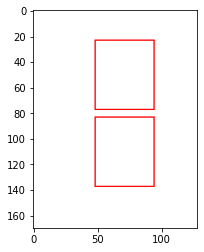

In [143]:
# cv2.rectangle(img2, (48, 23), (94, 77), (0, 0, 255), 1)
# cv2.rectangle(img2, (48, 83), (94, 137), (0, 0, 255), 1)
# plt.imshow(img2[:, :, ::-1])
# plt.show()

Reconstruction: 100%|██████████| 21760/21760 [00:00<00:00, 528244.98it/s]


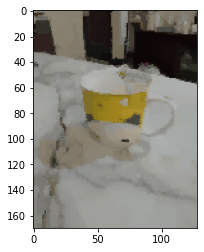

Reconstruction: 100%|██████████| 21760/21760 [00:00<00:00, 513246.48it/s]


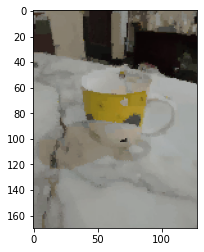

Reconstruction: 100%|██████████| 21760/21760 [00:00<00:00, 490285.17it/s]


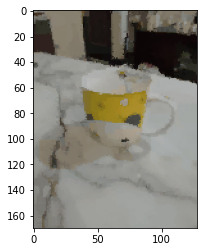

Reconstruction: 100%|██████████| 21760/21760 [00:00<00:00, 496038.21it/s]


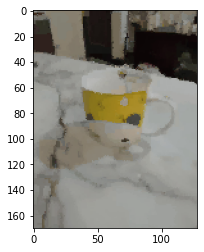

Reconstruction: 100%|██████████| 21760/21760 [00:00<00:00, 506827.94it/s]


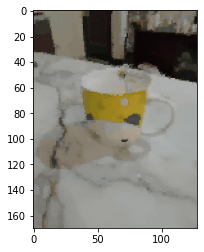

21.48


In [150]:
n_jobs = 16
p_size = 3
num_itr = 5

start = time()
f = NNS(img1.copy(), img2.copy(), p_size, num_itr)
# f = NNS(img1.copy(), img2.copy(), p_size, num_itr, (((23, 48), (77, 94)), ((83, 48), (137, 94))))
# f = NNS(img2, img2, p_size, num_itr, (((100, 180), (320, 380)), ((400, 180), (620, 380))))
print("%.2f" % (time() - start))